# Microsoft Azure Study Jam 3.0 Hackathon - Regression Challenge

###Author: Anik Chowdhury


## Instructions

Your task is to train a model to predict the column **target** using rest of the columns from the training dataset.

Then predict the test using the columns in the test dataset using your model. 

You will be judged by the accuracy of the model based on the test dataset. RMSE will be used to calculate accuracy. 

Email your predictions (5640 rows,1 column) to sj3hackathon@gmail.com . Include your name, slack name, team name in the email. If you have any questions, please contact Sandeep Pawar or Sayeh Ahmed on Slack.

To get you started, we have probvided the links to the datasets below. 

Good luck !!




**Import Libraries**

In [ ]:
!pip install --user pandas-profiling
import pandas as pd
import pandas_profiling
import numpy as np
import xgboost as xgb
%matplotlib inline
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

**Data Read**

In [ ]:
train_path = "https://raw.githubusercontent.com/pawarbi/datasets/master/train_sj3.csv"
test_path = "https://raw.githubusercontent.com/pawarbi/datasets/master/test_sj3.csv"
target_result = "https://raw.githubusercontent.com/nikitow1/Html-parser-clojure/master/regression_results2.csv"

# You can also download the csv files from 
# https://drive.google.com/drive/folders/1kiQ3HVgVIInlqnsLCk7WlzvxNcFOz9Pr?usp=sharing

## Training Dataset

In [ ]:
train_df = pd.read_csv(train_path)
target_data = pd.read_csv(target_result, sep='\t',encoding='utf-16')
train_df.head()

col0      col1       col2       col3  ...  col7        col8   col9       target
0   924  3.000000  70.064256  24.020824  ...  cat2  398.455102  cat13  1416.142572
1   956  4.898979  56.267220  20.591260  ...  cat2   70.823087   cat2  1416.142572
2  1583  4.242641  94.620294  32.771939  ...  cat2  770.742788  cat11  1416.142572
3  1586  4.000000  87.641314  30.757113  ...  cat2  751.995992  cat13  1416.142572
4  3487  3.162278  87.549986  31.606961  ...  cat2  695.048624   cat5  1416.142572

[5 rows x 11 columns]

In [ ]:
train_df.shape

(15000, 11)

**Missing Data Management**

In [ ]:
train_df.isnull().sum()

col0         0
col1         0
col2         0
col3       144
col4         0
col5         0
col6         0
col7         0
col8         0
col9      1106
target       0
dtype: int64

In [ ]:
corrMatrix = train_df.corr()
corrMatrix

col0      col1      col2  ...      col6      col8    target
col0    1.000000 -0.230137  0.114571  ...  0.069024  0.007039  0.005265
col1   -0.230137  1.000000 -0.400555  ... -0.152684 -0.012324  0.060925
col2    0.114571 -0.400555  1.000000  ...  0.263809  0.004369  0.169948
col3    0.092779 -0.352843  0.933712  ...  0.013604 -0.001108  0.061701
col4    0.079706 -0.305811  0.847610  ...  0.014379  0.003645 -0.026875
col5    0.078693 -0.320990  0.919593  ...  0.041312 -0.001712  0.080895
col6    0.069024 -0.152684  0.263809  ...  1.000000  0.009609  0.686755
col8    0.007039 -0.012324  0.004369  ...  0.009609  1.000000 -0.007190
target  0.005265  0.060925  0.169948  ...  0.686755 -0.007190  1.000000

[9 rows x 9 columns]

In [ ]:
train_df.profile_report()


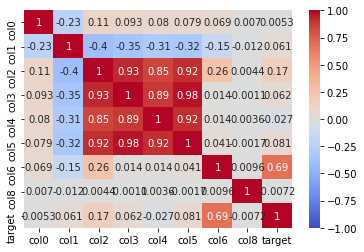

In [ ]:
sn.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.show()

In [ ]:
#drop the features with low co-relation with target variable
train_df.drop(['col9','col0','col8'], axis=1, inplace=True)
train_df.columns

Index(['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'target'], dtype='object')

In [ ]:
train_df.head()

col1       col2       col3  ...      col6  col7       target
0  3.000000  70.064256  24.020824  ...  3.117595  cat2  1416.142572
1  4.898979  56.267220  20.591260  ...  2.886815  cat2  1416.142572
2  4.242641  94.620294  32.771939  ...  3.276767  cat2  1416.142572
3  4.000000  87.641314  30.757113  ...  3.086600  cat2  1416.142572
4  3.162278  87.549986  31.606961  ...  3.298560  cat2  1416.142572

[5 rows x 8 columns]

In [ ]:
columnsToEncode=train_df.select_dtypes(include=[object]).columns
train_df = pd.get_dummies(train_df, columns=columnsToEncode, drop_first=True)
train_df.head()

col1       col2       col3  ...  col7_cat3  col7_cat4  col7_cat6
0  3.000000  70.064256  24.020824  ...          0          0          0
1  4.898979  56.267220  20.591260  ...          0          0          0
2  4.242641  94.620294  32.771939  ...          0          0          0
3  4.000000  87.641314  30.757113  ...          0          0          0
4  3.162278  87.549986  31.606961  ...          0          0          0

[5 rows x 11 columns]

**Fill the missing values with median in Col3**

In [ ]:
train_df['col3'].describe()

count    14856.000000
mean        21.952897
std          7.712690
min          1.414214
25%         17.146428
50%         20.784610
75%         25.396850
max         80.280757
Name: col3, dtype: float64

In [ ]:
col3_mean = train_df['col3'].mean()
col3_mean

21.95289724205983

In [ ]:
col3_median = train_df['col3'].median()
col3_median

20.78460969

In [ ]:
train_df.col3.fillna(col3_median, inplace=True)
train_df.isnull().sum()

col1         0
col2         0
col3         0
col4         0
col5         0
col6         0
target       0
col7_cat2    0
col7_cat3    0
col7_cat4    0
col7_cat6    0
dtype: int64

In [ ]:
train_df_mod_xgboost = train_df
train_df_mod_xgboost.head()

col1       col2       col3  ...  col7_cat3  col7_cat4  col7_cat6
0  3.000000  70.064256  24.020824  ...          0          0          0
1  4.898979  56.267220  20.591260  ...          0          0          0
2  4.242641  94.620294  32.771939  ...          0          0          0
3  4.000000  87.641314  30.757113  ...          0          0          0
4  3.162278  87.549986  31.606961  ...          0          0          0

[5 rows x 11 columns]

In [ ]:
train_dmatrix = xgb.DMatrix(data=train_df_mod_xgboost.iloc[:,:-1], label=train_df_mod_xgboost.target)
train_dmatrix

**Modelling & Training (Xgboost)**

In [ ]:
X1, y1 = train_df_mod_xgboost.drop(['target'], axis = 1), train_df_mod_xgboost['target']
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [ ]:
X_train1 = X_train1.values
X_test1 = X_test1.values

**XGBOOST**

In [ ]:
clf = xgb.XGBRegressor(objective='reg:squarederror')
clf.fit(X_train1,y_train1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
predictions_X = clf.predict(X_test1)

**MAE, MSE, RMSE**

In [ ]:
print("MAE:", metrics.mean_absolute_error(y_test1, predictions_X))
print('MSE:', metrics.mean_squared_error(y_test1, predictions_X))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test1, predictions_X)))

MAE: 142.1384996061507
MSE: 42692.36169176949
RMSE: 206.62130018894348


## Test Dataset

In [ ]:
test_df = pd.read_csv(test_path)
test_df.head()

col0      col1       col2       col3  ...      col6  col7        col8   col9
0  15617  7.211103  36.249138  17.804494  ...  2.084994  cat1  432.488573   cat5
1  15618  7.211103  53.404120  24.103942  ...  2.841742  cat1  151.342594  cat11
2  15619  7.211103  70.604532  36.810325  ...  2.218355  cat1  385.458208   cat2
3  15621  7.211103  27.221315  13.038405  ...  2.114521  cat1   20.638930    NaN
4  15622  7.211103  50.823223  25.922963  ...  1.774176  cat1  709.821361  cat15

[5 rows x 10 columns]

In [ ]:
test_df.shape

(5640, 10)

In [ ]:
test_df.isnull().sum()

col0      0
col1      0
col2      0
col3     63
col4      0
col5      0
col6      0
col7      0
col8      0
col9    418
dtype: int64

In [ ]:
col3_median_test = test_df['col3'].median()
col3_median_test

21.02379604

In [ ]:
test_df.col3.fillna(col3_median_test, inplace=True)
test_df.isnull().sum()

col0      0
col1      0
col2      0
col3      0
col4      0
col5      0
col6      0
col7      0
col8      0
col9    418
dtype: int64

In [ ]:
test_df.drop(['col9','col0','col8'], axis=1, inplace=True)
test_df.head()

col1       col2       col3       col4       col5      col6  col7
0  7.211103  36.249138  17.804494  21.748563  15.811388  2.084994  cat1
1  7.211103  53.404120  24.103942  28.948230  22.583180  2.841742  cat1
2  7.211103  70.604532  36.810325  42.988371  35.425979  2.218355  cat1
3  7.211103  27.221315  13.038405  16.643317  12.845233  2.114521  cat1
4  7.211103  50.823223  25.922963  36.537652  24.758837  1.774176  cat1

In [ ]:
columnsToEncode=test_df.select_dtypes(include=[object]).columns
test_df = pd.get_dummies(test_df, columns=columnsToEncode, drop_first=True)
test_df.head()

col1       col2       col3  ...  col7_cat2  col7_cat3  col7_cat6
0  7.211103  36.249138  17.804494  ...          0          0          0
1  7.211103  53.404120  24.103942  ...          0          0          0
2  7.211103  70.604532  36.810325  ...          0          0          0
3  7.211103  27.221315  13.038405  ...          0          0          0
4  7.211103  50.823223  25.922963  ...          0          0          0

[5 rows x 9 columns]

In [ ]:
test_df_xgboost = test_df
test_df_xgboost['col7_cat4'] = 0

In [ ]:
test_df_xgboost.head()

col1       col2       col3  ...  col7_cat3  col7_cat6  col7_cat4
0  7.211103  36.249138  17.804494  ...          0          0          0
1  7.211103  53.404120  24.103942  ...          0          0          0
2  7.211103  70.604532  36.810325  ...          0          0          0
3  7.211103  27.221315  13.038405  ...          0          0          0
4  7.211103  50.823223  25.922963  ...          0          0          0

[5 rows x 10 columns]

# Predictions

Your predictions on the test set will look like below with 1 column and 5640 rows

**Prediction on test data (Xgboost)**

In [ ]:
predictions_test_xgboost = clf.predict(test_df_xgboost.values)

In [ ]:
predictions_test_xgboost

array([ 732.70776, 1466.3005 ,  935.48444, ...,  645.63666,  673.0673 ,
        532.4439 ], dtype=float32)

In [ ]:
print('Train data RMSE:', np.sqrt(metrics.mean_squared_error(y_test1, predictions_X)))
print('Test data RMSE:', np.sqrt(metrics.mean_squared_error(target_data, predictions_test_xgboost)))

Train data RMSE: 206.62130018894348
Test data RMSE: 247.27708431281053


In [ ]:
test_df_xg.to_csv('test_target_xg.csv',index=False)